In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

import torch
import torch.nn as nn
from torch.nn import functional as F### Set up hyperparameters:

In [2]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 1000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

### Load in data and create train and test datasets

We're going to be using the tiny Shakespeare dataset. 
Data is tokenized according to a simple character based tokenizer.
Data is split into a train and test set so we have something to test after performing training (9:1 split).

In [3]:
with open('dataset/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

### Set up the components of the Decoder block: 
* MultiHeadAttention
* FeedForward Network

In [4]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) 16,32,16
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projection layer going back into the residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


### Combine components into the Decoder block

In [5]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # Communication
        x = x + self.ffwd(self.ln2(x))  # Computation
        return x

### Set up the full Transformer model 
This is a combination of the Token embeddings, Positional embeddings, a stack of Transformer blocks and an output block.

In [6]:
# super simple language model
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



We will be training a larger LLM on distributed resources in session 6.

## Homework

1. In this notebook, we learned the various components of an LLM. 
    Your homework this week is to take the mini LLM we created from scratch and run your own training loop. Show how the training and validation perplexity change over the steps.
      
    Hint: this function might be useful for you:

In [7]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

2. Run the same training loop but modify one of the hyperparameters from this list: 

In [8]:
# hyperparameters
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4

Run this at least 4 times with a different value and plot each perplexity over training step. Write a sentence on how the perplexity changed.

Bonus 1: output some generated text from each model you trained. Did the output make more sense with some hyperparameters than others? 

Bonus 2: We saw a cool visualization of attention mechanisms with BertViz. Take a more complicated model than GPT2 such as "meta-llama/Llama-2-7b-chat-hf" and see how the attention mechanisms are different 

## References

Here are some recommendations for further reading and additional code for review.

* "The Illustrated Transformer" by Jay Alammar
* "Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention)"
* "The Illustrated GPT-2 (Visualizing Transformer Language Models)"
* "A gentle introduction to positional encoding"
* "LLM Tutorial Workshop (Argonne National Laboratory)"
* "LLM Tutorial Workshop Part 2 (Argonne National Laboratory)"

In [9]:
from tqdm import tqdm

def train_one_epoch(model, optimizer):
    model.train()
    for _ in tqdm(range(max_iters)):
        X, Y = get_batch("train")
        # forward pass
        logits, loss = model(X, Y)    

        # backward pass calculates gradients
        loss.backward()    

        # take one step with these gradients
        optimizer.step()    

        # resets the gradients 
        optimizer.zero_grad()      

In [10]:
epochs = 10
# hyperparameters
max_iters = 1000
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4

model = LanguageModel()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
model.to(device)

perplexity = []
for j in range(epochs):
    train_one_epoch(model, optimizer)
    out = estimate_loss()
    print(j, out)
    ptrain = torch.exp(out['train']).numpy()
    pval = torch.exp(out['val']).numpy()
    perplexity.append([j, ptrain, pval])
print(perplexity)

100%|██████████| 1000/1000 [00:13<00:00, 71.94it/s]


0 {'train': tensor(2.1083), 'val': tensor(2.1458)}


100%|██████████| 1000/1000 [00:14<00:00, 70.67it/s]


1 {'train': tensor(1.8840), 'val': tensor(1.9739)}


100%|██████████| 1000/1000 [00:14<00:00, 70.66it/s]


2 {'train': tensor(1.7789), 'val': tensor(1.9163)}


100%|██████████| 1000/1000 [00:14<00:00, 70.67it/s]


3 {'train': tensor(1.7088), 'val': tensor(1.8679)}


100%|██████████| 1000/1000 [00:14<00:00, 70.66it/s]


4 {'train': tensor(1.6632), 'val': tensor(1.8168)}


100%|██████████| 1000/1000 [00:14<00:00, 70.66it/s]


5 {'train': tensor(1.6307), 'val': tensor(1.8031)}


100%|██████████| 1000/1000 [00:14<00:00, 70.66it/s]


6 {'train': tensor(1.6002), 'val': tensor(1.7791)}


100%|██████████| 1000/1000 [00:14<00:00, 70.66it/s]


7 {'train': tensor(1.5974), 'val': tensor(1.7665)}


100%|██████████| 1000/1000 [00:14<00:00, 70.66it/s]


8 {'train': tensor(1.5697), 'val': tensor(1.7528)}


100%|██████████| 1000/1000 [00:14<00:00, 70.64it/s]


9 {'train': tensor(1.5572), 'val': tensor(1.7350)}
[[0, array(8.234115, dtype=float32), array(8.549198, dtype=float32)], [1, array(6.579549, dtype=float32), array(7.198935, dtype=float32)], [2, array(5.9231606, dtype=float32), array(6.7960806, dtype=float32)], [3, array(5.522172, dtype=float32), array(6.4749084, dtype=float32)], [4, array(5.2761703, dtype=float32), array(6.151872, dtype=float32)], [5, array(5.107561, dtype=float32), array(6.0686393, dtype=float32)], [6, array(4.9542227, dtype=float32), array(5.924788, dtype=float32)], [7, array(4.9401317, dtype=float32), array(5.8501406, dtype=float32)], [8, array(4.805149, dtype=float32), array(5.770508, dtype=float32)], [9, array(4.745494, dtype=float32), array(5.669071, dtype=float32)]]


In [12]:
epochs = 10
# hyperparameters
max_iters = 1000
n_embd = 64
n_heads = [1, 2, 4, 8]
n_layer = 4

model = LanguageModel()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
model.to(device)

perplexity_nhead = {}
for n_head in n_heads:
    perplexity = []
    for j in range(epochs):
        train_one_epoch(model, optimizer)
        out = estimate_loss()
        print(j, out)
        ptrain = torch.exp(out['train']).numpy()
        pval = torch.exp(out['val']).numpy()
        perplexity.append([j, ptrain, pval])
    perplexity_nhead[n_head] = np.array(perplexity)

100%|██████████| 1000/1000 [00:14<00:00, 70.41it/s]


0 {'train': tensor(2.0801), 'val': tensor(2.1134)}


100%|██████████| 1000/1000 [00:14<00:00, 70.64it/s]


1 {'train': tensor(1.8502), 'val': tensor(1.9607)}


100%|██████████| 1000/1000 [00:14<00:00, 70.66it/s]


2 {'train': tensor(1.7400), 'val': tensor(1.8980)}


100%|██████████| 1000/1000 [00:14<00:00, 70.64it/s]


3 {'train': tensor(1.6861), 'val': tensor(1.8595)}


100%|██████████| 1000/1000 [00:14<00:00, 70.67it/s]


4 {'train': tensor(1.6473), 'val': tensor(1.8107)}


100%|██████████| 1000/1000 [00:14<00:00, 70.64it/s]


5 {'train': tensor(1.6144), 'val': tensor(1.7754)}


100%|██████████| 1000/1000 [00:14<00:00, 70.66it/s]


6 {'train': tensor(1.5958), 'val': tensor(1.7904)}


100%|██████████| 1000/1000 [00:14<00:00, 70.64it/s]


7 {'train': tensor(1.5772), 'val': tensor(1.7636)}


100%|██████████| 1000/1000 [00:14<00:00, 70.66it/s]


8 {'train': tensor(1.5516), 'val': tensor(1.7299)}


100%|██████████| 1000/1000 [00:14<00:00, 70.60it/s]


9 {'train': tensor(1.5472), 'val': tensor(1.7368)}


100%|██████████| 1000/1000 [00:14<00:00, 70.66it/s]


0 {'train': tensor(1.5252), 'val': tensor(1.7229)}


100%|██████████| 1000/1000 [00:14<00:00, 70.59it/s]


1 {'train': tensor(1.5258), 'val': tensor(1.7344)}


100%|██████████| 1000/1000 [00:14<00:00, 70.64it/s]


2 {'train': tensor(1.5159), 'val': tensor(1.7149)}


100%|██████████| 1000/1000 [00:14<00:00, 70.61it/s]


3 {'train': tensor(1.5254), 'val': tensor(1.7108)}


100%|██████████| 1000/1000 [00:14<00:00, 70.65it/s]


4 {'train': tensor(1.5098), 'val': tensor(1.6999)}


100%|██████████| 1000/1000 [00:14<00:00, 70.61it/s]


5 {'train': tensor(1.5066), 'val': tensor(1.6961)}


100%|██████████| 1000/1000 [00:14<00:00, 70.66it/s]


6 {'train': tensor(1.4839), 'val': tensor(1.6845)}


100%|██████████| 1000/1000 [00:14<00:00, 70.61it/s]


7 {'train': tensor(1.4912), 'val': tensor(1.6799)}


100%|██████████| 1000/1000 [00:14<00:00, 70.63it/s]


8 {'train': tensor(1.4795), 'val': tensor(1.6919)}


100%|██████████| 1000/1000 [00:14<00:00, 70.65it/s]


9 {'train': tensor(1.4880), 'val': tensor(1.6828)}


100%|██████████| 1000/1000 [00:14<00:00, 70.59it/s]


0 {'train': tensor(1.4819), 'val': tensor(1.6805)}


100%|██████████| 1000/1000 [00:14<00:00, 70.63it/s]


1 {'train': tensor(1.4685), 'val': tensor(1.6631)}


100%|██████████| 1000/1000 [00:14<00:00, 70.63it/s]


2 {'train': tensor(1.4677), 'val': tensor(1.6816)}


100%|██████████| 1000/1000 [00:14<00:00, 70.65it/s]


3 {'train': tensor(1.4647), 'val': tensor(1.6471)}


100%|██████████| 1000/1000 [00:14<00:00, 70.60it/s]


4 {'train': tensor(1.4649), 'val': tensor(1.6594)}


100%|██████████| 1000/1000 [00:14<00:00, 70.68it/s]


5 {'train': tensor(1.4546), 'val': tensor(1.6541)}


100%|██████████| 1000/1000 [00:14<00:00, 70.64it/s]


6 {'train': tensor(1.4531), 'val': tensor(1.6515)}


100%|██████████| 1000/1000 [00:14<00:00, 70.67it/s]


7 {'train': tensor(1.4455), 'val': tensor(1.6564)}


100%|██████████| 1000/1000 [00:14<00:00, 70.64it/s]


8 {'train': tensor(1.4495), 'val': tensor(1.6593)}


100%|██████████| 1000/1000 [00:14<00:00, 70.67it/s]


9 {'train': tensor(1.4430), 'val': tensor(1.6691)}


100%|██████████| 1000/1000 [00:14<00:00, 70.67it/s]


0 {'train': tensor(1.4495), 'val': tensor(1.6571)}


100%|██████████| 1000/1000 [00:14<00:00, 70.62it/s]


1 {'train': tensor(1.4470), 'val': tensor(1.6609)}


100%|██████████| 1000/1000 [00:14<00:00, 70.66it/s]


2 {'train': tensor(1.4400), 'val': tensor(1.6481)}


100%|██████████| 1000/1000 [00:14<00:00, 70.68it/s]


3 {'train': tensor(1.4369), 'val': tensor(1.6311)}


100%|██████████| 1000/1000 [00:14<00:00, 70.65it/s]


4 {'train': tensor(1.4430), 'val': tensor(1.6450)}


100%|██████████| 1000/1000 [00:14<00:00, 70.67it/s]


5 {'train': tensor(1.4373), 'val': tensor(1.6581)}


100%|██████████| 1000/1000 [00:14<00:00, 70.58it/s]


6 {'train': tensor(1.4288), 'val': tensor(1.6428)}


100%|██████████| 1000/1000 [00:14<00:00, 70.67it/s]


7 {'train': tensor(1.4233), 'val': tensor(1.6358)}


100%|██████████| 1000/1000 [00:14<00:00, 70.67it/s]


8 {'train': tensor(1.4237), 'val': tensor(1.6279)}


100%|██████████| 1000/1000 [00:14<00:00, 70.65it/s]


9 {'train': tensor(1.4205), 'val': tensor(1.6392)}


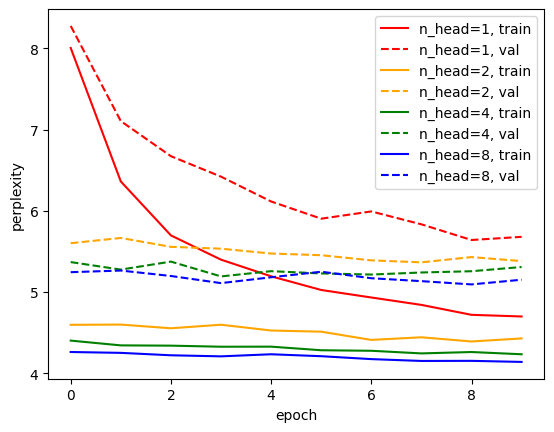

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)
color = {1:'red', 2:'orange', 4:'green', 8:'blue'}
for key in perplexity_nhead:
    ax.plot(perplexity_nhead[key][:,0], perplexity_nhead[key][:,1], c=color[key], ls='-', label='n_head=%d, train' % key)
    ax.plot(perplexity_nhead[key][:,0], perplexity_nhead[key][:,2], c=color[key], ls='--', label='n_head=%d, val' % key)
ax.set_xlabel('epoch')
ax.set_ylabel('perplexity')
ax.legend()

With increasing number of heads from 1 to 8, the perplexity decreases.

In [23]:
input_text = "Once upon a time, there was a little wolf"
input_data = torch.tensor(encode(input_text), dtype=torch.long).reshape([1,-1]).to(device)
logit = model.generate(input_data,30)
output_text = decode(logit[0].to('cpu').numpy())
print(output_text)

Once upon a time, there was a little wolf in honour,
Why, hath thou can
